In [1]:
import numpy as np
from nb_utils import *
#%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
import re

%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
def load_info_from_file(npz_path, model_name='ResNet18', **kwargs):
    results_dict = dict(np.load(npz_path, allow_pickle=True))
    elr = kwargs.get("elr")
    elr = np.ones(len(results_dict['report_epochs']))*elr
    
    params_dict = kwargs.get("params_dict")
    
    results_dict["elr"] = elr
    prebn_pnorm_sqr = 0.0
    prebn_numel = 0
    
    for key in list(results_dict.keys()):
        if "acc" in key:
            results_dict[key.replace("acc", "error")] = 1.0 - results_dict[key]  
        elif "_norm" in key and key != "params_norm":
            p_name = key[:-5]
            if check_si_name(p_name, model_name):
                p_norm_sqr = results_dict[key] ** 2
                prebn_pnorm_sqr += p_norm_sqr
                if params_dict is not None:
                    p_numel = params_dict[p_name].numel()
                    prebn_numel += p_numel
    
    if not isinstance(prebn_pnorm_sqr, float):
        results_dict["prebn_pnorm"] = np.sqrt(prebn_pnorm_sqr)
        if "linear_layers.2.weight_norm" in results_dict.keys():
            results_dict["postbn_pnorm"] = np.sqrt(results_dict["linear_layers.2.weight_norm"]**2 + 
                                               results_dict["linear_layers.2.bias_norm"]**2)
        lr = elr * prebn_pnorm_sqr
        results_dict["lr"] = lr
        F_tr = results_dict.get("fisher_trace")
        if F_tr is not None:
            # reduced F_tr is almost the same as effective F_tr when the fraction of SI-params is high
            results_dict["fisher_trace_r"] = F_tr * prebn_pnorm_sqr  
            results_dict["fisher_trace_r_x_elr"] = results_dict["fisher_trace_r"] * results_dict["elr"]
    
    return results_dict

def post_load_prebn(results,fns):
    for fn in fns:
        if results[fn]['train'] is not None and results[fn]['train_prebn'] is not None:
            results[fn]['train']['prebn_gm_norm'] = results[fn]['train_prebn']['gm_norm']
            results[fn]['train']['postbn_gm_norm'] = np.sqrt(results[fn]['train']['gm_norm'] ** 2 - 
                                                             results[fn]['train_prebn']['gm_norm'] ** 2)
            
            results[fn]['train']['prebn_gs_norm'] = results[fn]['train_prebn']['gs_norm']
            results[fn]['train']['postbn_gs_norm'] = np.sqrt(results[fn]['train']['gs_norm'] ** 2 - 
                                                             results[fn]['train_prebn']['gs_norm'] ** 2)
            
            results[fn]['train']['prebn_gm_norm_eff'] = (results[fn]['train']['prebn_gm_norm']*
                                                         results[fn]['train']['prebn_pnorm'])
            results[fn]['train']['prebn_gs_norm_eff'] = (results[fn]['train']['prebn_gs_norm']*
                                                         results[fn]['train']['prebn_pnorm'])
            
            results[fn]['train']['prebn_fisher_trace'] = results[fn]['train_prebn']['fisher_trace']
            results[fn]['train']['prebn_fisher_trace_eff'] = (results[fn]['train_prebn']['fisher_trace']*
                                                         results[fn]['train']['prebn_pnorm']**2)
            results[fn]['train']['prebn_fisher_trace_eff_x_elr'] = (results[fn]['train']['prebn_fisher_trace_eff']*
                                                                    results[fn]['train']['elr'])
            #results[fn]['train']["fisher_trace_r"] = results[fn]['train']['prebn_fisher_trace_eff']
            #results[fn]['train']["fisher_trace_r_x_elr"] = results[fn]['train']['prebn_fisher_trace_eff_x_elr']
            
            
            all_numel = results[fn]['train']["params_numel"]
            prebn_numel = results[fn]['train_prebn']["params_numel"]
            others_numel = all_numel - prebn_numel
            w_all, w_prebn = all_numel / others_numel, prebn_numel / others_numel
            
            results[fn]['train']['postbn_fisher_trace'] = (w_all * results[fn]['train']['fisher_trace'] - 
                                                           w_prebn * results[fn]['train_prebn']['fisher_trace'])
                
    return results
            

def load_info(folder_info,fns,model_name='ResNet18',elr_flag = True):
    results_info = {}
    
    for fn in fns:
        result = {'train': None, 'train_prebn': None, 'test': None}
        if 'train-tm.npz' in listdir(folder_info+fn):
                result['train'] = load_info_from_file(folder_info + fn +'/train-tm.npz', 
                                                      model_name=model_name, elr=float(fn.split('_')[2][3:]) 
                                                      if elr_flag else 0)
        if 'train-tm-prebn.npz' in listdir(folder_info+fn):
                result['train_prebn'] = load_info_from_file(folder_info + fn +'/train-tm-prebn.npz', 
                                                      model_name=model_name, elr=float(fn.split('_')[2][3:])
                                                            if elr_flag else 0)
        if 'test-em.npz' in listdir(folder_info+fn):
                result['test'] = load_info_from_file(folder_info + fn +'/test-em.npz', 
                                                      model_name=model_name, elr=float(fn.split('_')[2][3:])
                                                    if elr_flag else 0)
        
        results_info[fn] = result
    #results_info = post_load_prebn(results_info,fns)
        
    return results_info

In [3]:
cols = sns.color_palette('gist_rainbow',30)
cols = [cols[0],cols[3],cols[5],cols[12],cols[18],cols[21],cols[26],cols[29]]
sns.set_palette(sns.color_palette(cols))
cols = sns.color_palette(cols)
cols

[(1.0, 0.007419183889772136, 0.0),
 (1.0, 0.5373608903020667, 0.0),
 (1.0, 0.8765235824059353, 0.0),
 (0.0, 1.0, 0.1054185114906178),
 (0.0, 0.8599744245524292, 1.0),
 (0.0, 0.32715260017050274, 1.0),
 (0.546675191815857, 0.0, 1.0),
 (1.0, 0.0, 0.9205029838022163)]

In [4]:
fig_shape_x = 6/1.6
fig_shape_y = 3./1.6

In [5]:
def plot_one_loss_paper(results,fns,data,loss,ax,yscale='log',xscale='linear',c=None,title = None):
    for fn in fns:
        if results[fn][data] is not None:
            if loss == 'acc':
                ax.plot((1-results[fn][data][loss])*100,label = fn,c=c,linewidth=1.3)
            elif loss == "gnorm_m" and data == 'train_prebn':
                gnorm = results[fn]['train_prebn']["gnorm_m"]
                gnorm = gnorm*results[fn]['train_prebn']["params_norm"]
                ax.plot(gnorm,label = fn,c=c,linewidth=1.3)
            else:
                ax.plot(results[fn][data][loss],label = fn,c=c,linewidth=1.3)
        else:
            ax.plot([],[])

    ax.set_yscale(yscale)
    ax.set_xscale(xscale)
    ax.grid()

    ax.set_xlabel('epoch',fontsize=11)
    if title is not None:
        ax.set_title(title,fontsize=12)
    else:
        if loss == 'acc' and data == 'test':
            ax.set_title('Test error, %',fontsize=12)
        elif loss == 'loss' and data == 'train':
            ax.set_title('Train loss',fontsize=12)
        elif loss == 'gnorm_m' and data == 'train_prebn':
            ax.set_title('Mean eff. gradient norm',fontsize=12)
        else:
            ax.set_title(data + ' ' + loss)
            
def plot_diagram_paper(results,fns,ax,metric_y,title = None,c=None,elr_flag=True):
    if title is not None:
        ax.set_title(title,fontsize=12)
    ax.set(xscale='log', yscale='log')
    ax.set_xlabel("train loss",fontsize=11)
    if metric_y == 'gnorm_m_prebn':
        ax.set_ylabel('mean eff. gradient norm',fontsize=11)
    elif metric_y == 'gnorm_m':
        ax.set_ylabel('mean gradient norm',fontsize=11)
    elif metric_y == 'test_err':
        ax.set_ylabel('test error, %',fontsize=11)
        
    for fn in fns:
        if metric_y == 'gnorm_m_prebn':
            y = results[fn]['train_prebn']['gnorm_m']*results[fn]['train_prebn']['params_norm']
            label = results[fn]['train']['elr'][-1] if elr_flag else float(fn.split('_')[2][2:])
        elif metric_y == 'gnorm_m':
            y = results[fn]['train']['gnorm_m']
            label = float(fn.split('_')[2][2:]) 
        elif metric_y == 'test_err':
            y = 100*(1-results[fn]['test']['acc'])
            label = results[fn]['train']['elr'][-1] if elr_flag else float(fn.split('_')[2][2:])
        ax.plot(results[fn]['train']['loss'],y,alpha=1,label=label,marker = '.',linewidth=1.3)
    ax.plot(results[fns[-1]]['train']['loss'][0], y[0], '*',c='k',label = 'starting point',markersize=7,alpha=0.8) 
    ax.grid()

## Fully scale-invariant, ConvNet, CIFAR10

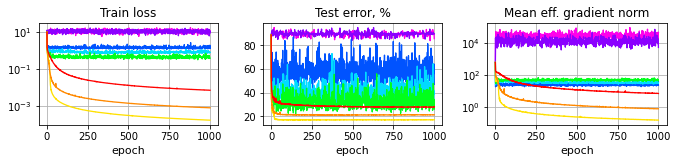

In [6]:
sns.set_palette(sns.color_palette(cols[::-1]))
exp_f = 'fix_elr/same_last_layer'

model_name = "ConvNetSI"
dataset_name = "CIFAR10"
fix_noninvlr = 0.0

if fix_noninvlr >= 0:
    folder_info = './Experiments/'+exp_f+'/{}_{}_noninvlr_{}/info/'.format(model_name,dataset_name,fix_noninvlr) 
else:
    folder_info = "./Experiments/"+exp_f+"/{}_{}/info/".format(model_name,dataset_name)
fns = listdir(folder_info)

fns_tmp = []
for fn in fns:
    if ('corr' not in fn and 'seed' not in fn and 'c32' in fn and 'noaug' in fn):
        fns_tmp.append(fn)
fns = fns_tmp
fns.sort(reverse=True)
elrs = []

results_info = load_info(folder_info,fns,model_name=model_name)

for fn in fns:
    elrs.append(results_info[fn]['train']['elr'][-1])
inds = np.argsort(np.array(elrs))
fns = [fns[i] for i in inds]
#fns = [fn for fn in fns if float(fn.split('_')[2][3:]) in [1e-5,1e-4,5e-4,1e-3,2e-3,5e-3,5e-2,1e-1]]
#print(fns)

fig, axes = plt.subplots(1,3,figsize = (fig_shape_x*3,fig_shape_y))
plot_one_loss_paper(results_info,fns[::-1],'train','loss',axes[0],yscale='log')
plot_one_loss_paper(results_info,fns[::-1],'test','acc',axes[1],yscale='linear')
plot_one_loss_paper(results_info,fns[::-1],'train_prebn','gnorm_m',axes[2],yscale='log')

plt.subplots_adjust(wspace=0.25)
#plt.savefig("figures/overview_lines.png", bbox_inches='tight', format='png',dpi=512)

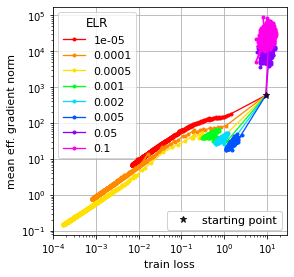

In [7]:
sns.set_palette(sns.color_palette(cols))
fig,axes = plt.subplots(1,1,figsize = (fig_shape_x*1.12,fig_shape_x*1.12))

plot_diagram_paper(results_info,fns,axes,'gnorm_m_prebn')

handles, labels = axes.get_legend_handles_labels()
legend = axes.legend(handles[:-1],labels[:-1],loc='upper left',fontsize=11,
                         title = 'ELR')
legend_stars = axes.legend([handles[-1]],[labels[-1]],loc='lower right',fontsize=11)
legend.get_title().set_fontsize('12')

axes.add_artist(legend)
axes.add_artist(legend_stars)

xlim = axes.get_xlim()
#plt.savefig("figures/overview_grad_diagram.png", bbox_inches='tight', format='png',dpi=512)